## Lesson 6: Seeing the Moon
#### Learning Objectives:
After completing this lesson, users will be able to:
1. objective 1
2. objective 2
3. objective 3

_Python libraries introduced in this lesson:_ [`netcdf4`](https://unidata.github.io/netcdf4-python/)

### Introduction

The Shinnecock are a federally recognized tribe based in eastern Long Island. Like many other tribes along the eastern seaboard, colonialism caused great hardship and loss for the Shinnecock. Land is put at the center of the colonialism discussion, but land is what the colonists gained; it is only the beginning of what indigenous tribes lost. Traditional language, ceremonies, and cultural practices were outlawed; children were taken away from their families; Shinnecock men were left to die on ships in storms while products were given preference to be taken ashore first. 

For several generations, the Shinnecock have been attempting to bring back lost cultural traditions, much of which has been done by travelling to other closely related communities and re-learning our ways. One of the recently revived traditions is the *Full Moon Ceremony* in which female members of the tribe honor _Nukimis Nanapashot_ (Grandmother Moon Spirit). The women of the tribe are tied to the water, the moon, and its calendar. Each month, when the moon is full and its power strongest, this ceremony is held to allow the participants to cleanse themselves and their energy.

Today, in Western science, the Moon is considered full on one particular date in the synodic month (New Moon to New Moon). However, this strict concept of fullness is not adhered to in the ceremonies. You may have noticed that the Moon "looks full" for a few days before and after the exact date of the full Moon.

In this notebook, we will use computer vision, in particular morphological analysis, to explore the fullness of the Moon and compare this to the dates on which the ceremony is permitted to be held.

Currently, Full Moon Ceremonies are practiced within three days on either side of the full Moon. Here we will use publicly available data to quantify the illumination percentage of the Moon throughout the higher illumination periods of its cycle, and relate this to the visual appearance of the Moon during the times in which the ceremony is practiced. Subsequently we'll use this information to back-compute possible ceremony dates from the past using ephemeris information.

### Background on the Dataset

For this analysis we will need a dataset of full-disk images of the Moon in various phases. Luckily, there are plenty of satellites that use the Moon to calibrate their instruments. They contribute to the [GLOD (GSICS Lunar
Observation Dataset)](http://gsics.atmos.umd.edu/bin/view/Development/LunarWorkArea) which accumulates the lunar data taken from these satellites to create a calibration model using the Moon. Unfortunately, the GLOD is not publicly shareable. However, the data of many of the satellites that contribute to it _are_ public. We will focus on the GOES-R series (that's GOES-16, GOES-17, and GOES-18) satellites [ABI instruments](https://www.goes-r.gov/spacesegment/abi.html). The data that these instruments use for calibration with the moon contains `LUN` in the filenames and can be obtained from [NOAA CLASS GRICABI dataset](https://www.aev.class.noaa.gov/saa/products/search?sub_id=0&datatype_family=GRICABI&submit.x=18&submit.y=6).

In generating this training we downloaded the entirety of the LUN dataset for all three satellites up to that date, and ran them all through the exercise you'll be doing here. That was about 700 GB and it's unrealistic to expect you to reproduce that scale of work! Instead, we've curated a small subset of the dataset so you can learn the same techniques (without having to go through the delay of waiting for your data order through NOAA CLASS or overloading your harddrive).

We've also massaged the data to make it a bit easier to work with. These files have been downsized to only include the data relevant for this exercise (radiance). The original GOES files also contain 2 or 4 frames within the same array. We have dissected and separated these arrays so each file represents only one frame. This merged frame style is something we only find in the calibration data, so if you work with GOES atmospheric data this isn't a step you'd need to consider. For a deeper dive into the preprocessing steps that were performed and how we chose the files to include in this subset you can check out the functions we used (which have docstrings with detailed descriptions) [here](https://gist.github.com/Sierra-MC/4aa3eb54ec3ce4ebeafac44468b61a1a).

You can download the data subset here: https://kts-dev-data.s3.amazonaws.com/goes/goes_subset_flat.tar.gz

You'll need to decompress ("ungzip" and "untar") the subset in order to use the data. Head to lesson 1 if you need a refresher on how to do that.

### NetCDF and Data Exploration
[NetCDF](https://www.unidata.ucar.edu/software/netcdf/) is a data storage format for scientific array-oriented data. It is very popular, especially in the Earth Sciences, and contains metadata within the same file as the data itself. GOES data is served in NetCDF format and the most recent version of the software used to open it, also named NetCDF, is currently NetCDF4 (at the time of writing this training). Let's begin by importing the python library to work with NetCDF data ([`netCDF4`](https://unidata.github.io/netcdf4-python/)) and opening one of our files to get a feel for what this format looks like.

In [20]:
from pathlib import Path

from netCDF4 import Dataset
import pandas as pd

# Global variables are useful for system-specific configuration.
# Set this to wherever you downloaded and decompressed the .nc files.
LUN_FOLDER = Path("../../goes_subset_flat/")

You can use the below cell to make sure you have the proper folder path. In it we are printing the length of a list of all the files in the folder you provided that have `LUN` in the name. If the value is zero you have mistyped the path and should edit and rerun the cell above.

In [21]:
print(len(list(LUN_FOLDER.rglob('*LUN*'))))

272


You can use the `Dataset` Class from netCDF4 to read a NetCDF file in. If we print the `Dataset` object we can see some metadata about our data.

In [34]:
lun_nc = Dataset(LUN_FOLDER / 'OR_ABI-INST-CAL-LUN-M3C01_G17_s20190232339569_e20190232339569_c20190232340140-t0-s1.nc')
lun_nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    instrument_type: GOES R Series Advanced Baseline Imager
    orbital_slot: GOES-West
    platform_ID: G17
    instrument_ID: FM2
    time_coverage_start: 2019-01-23T23:39:56.924685Z
    time_coverage_end: 2019-01-23T23:39:56.924685Z
    license: CC0 (Million Concepts) 'Unclassified data. Access is restricted to approved users only.' (DOC/NOAA/NESDIS) [approval granted for users of Knowing the Sky]
    institution: Million Concepts/DOC/NOAA/NESDIS
    date_created: 2024-04-09T17:51:00Z
    title: ABI Lunar Scan Calibrated Sample Data (flattened from t 0, swath 1)
    dimensions(sizes): lines(676), samples(2808)
    variables(dimensions): float32 radiance(lines, samples)
    groups: 

The metadata tells us that this is a GOES-17 ABI image taken on 1-23-2019 at 23:39 (11:39 pm). In the `variables` attribute we can access the `radiance` data we are interested in with the following syntax:

In [44]:
rad = lun_nc.variables['radiance']
rad

<class 'netCDF4._netCDF4.Variable'>
float32 radiance(lines, samples)
unlimited dimensions: 
current shape = (676, 2808)
filling off

Now that we have the radiance data isolated, let's plot it in grayscale and see what the image we have looks like.

In [45]:
import matplotlib.pyplot as plt

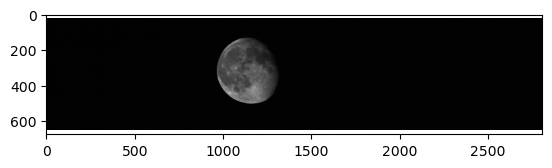

In [46]:
plt.imshow(rad, cmap='gray')

Alright! That's a nice image of the moon! Let's look at a few other files to get a feel for the variety in the dataset:

In [87]:
rad1 = Dataset(LUN_FOLDER / 'OR_ABI-INST-CAL-LUN-M6C03_G17_s20222801900592_e20222801901048_c20222801901103-t0-s0.nc').variables['radiance']
rad2 = Dataset(LUN_FOLDER / 'OR_ABI-INST-CAL-LUN-M6C05_G16_s20221992056556_e20221992057011_c20221992057088-t0-s1.nc').variables['radiance']
rad3 = Dataset(LUN_FOLDER / 'OR_ABI-INST-CAL-LUN-M6C01_G16_s20223651143552_e20223651144007_c20223651144148-t0-s1.nc').variables['radiance']
rad4 = Dataset(LUN_FOLDER / 'OR_ABI-INST-CAL-LUN-M6C03_G16_s20231201315549_e20231201316004_c20231201316063-t0-s0.nc').variables['radiance']

And we can plot those all in one plot using subplots:

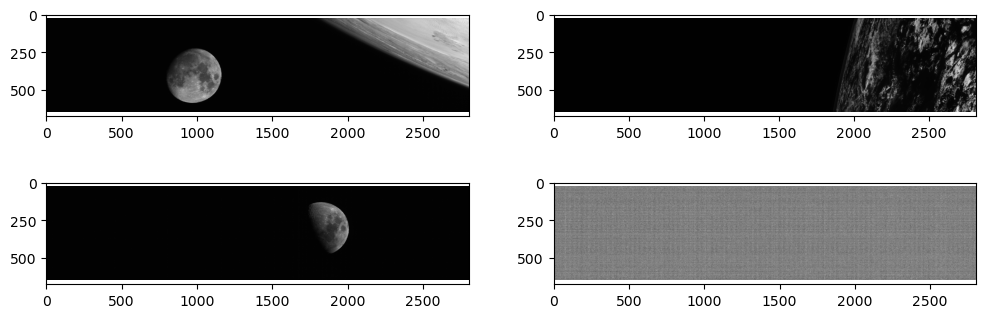

In [88]:
fig = plt.figure(figsize=(12,4))
rad_list = [rad1, rad2, rad3, rad4]
for i in range(1,5):
    fig.add_subplot(2,2,i)
    plt.imshow(rad_list[i-1], cmap='gray')

Well. It looks like we have more than just simple, nice moon images here. This is going to take some more work to create a clean moon-only dataset to detect phases with!

# introduction to morphological analysis
----
## placeholder for section

# moon extraction pipeline (technical skeleton
## we will notionally build this up piece by piece

In [456]:
import cv2
import numpy as np
import scipy.ndimage as ndi

def a2c(area: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """Area of a circle."""
    return 2 * np.pi * np.sqrt(area / np.pi)


def gethull(blob: np.ndarray) -> np.ndarray:
    """
    Compute the convex hull of the "shape" contained in `blob`, which should be
    a 2D ndarray of 8-bit unsigned integers valued either 0 or 1; 1 represents
    "foreground". Returns a 2D ndarray whose rows are the vertices of the hull
    and whose 2 columns represent the X and Y indices of each vertex.
    """
    hull = cv2.convexHull(np.vstack(np.nonzero(blob)).T)
    return np.flip(hull, axis=2)


def filter_labels(
    arr: np.ndarray, 
    labels: np.ndarray, 
    bordersize: int, 
    min_moon_extent: int
) -> tuple[dict, dict, dict]:
    """
    Filter 'bad' labels: labels that are too small or that come 
    within a specified range of the top/bottom/left/right of the image.
    """
    label_indices = {
        label: np.nonzero(labels == label)
        for label in np.unique(labels)
        if label != 0
    }
    label_rejects = {}
    for label, (yix, xix) in label_indices.items():
        if min([np.ptp(xix), np.ptp(yix)]) < min_moon_extent:
            label_rejects[label] = 'small'
        elif (xix <= bordersize).any():
            label_rejects[label] = 'left'
        elif (arr.shape[1] - xix <= bordersize).any():
            label_rejects[label] = 'right'
        elif (yix <= bordersize).any():
            label_rejects[label] = 'top'
        elif (arr.shape[0] - yix <= bordersize).any():
            label_rejects[label] = 'bottom'
    remaining = {
        k: v for k, v in label_indices.items()
        if k not in label_rejects.keys()
    }
    return remaining, label_rejects, label_indices


def moon_extraction_error(rec: dict, n_remaining: int) -> dict:
    if n_remaining == 0:
        return rec | {'error': 'no Moon', 'moon': None}
    if n_remaining > 1:
        return rec | {'error': 'ambiguous Moon', 'moon': None}
    raise ValueError("How did we get here?")


def get_moon_cutout(remaining: dict, moonpad: int) -> list[slice]:
    moon_y, moon_x = next(iter(remaining.values()))
    y0, y1, x0, x1 = moon_y.min(), moon_y.max(), moon_x.min(), moon_x.max()
    return [
        slice(max(y0 - moonpad, 0), y1 + moonpad),
        slice(max(x0 - moonpad, 0), x1 + moonpad)
    ]


def mooncircle(labels, moonslice, moonlabel) -> dict:
    """
    Given a dict containing a label array (keyed "labels") and a tuple of
    Y/X slices giving the bounds of a detected "Moon" (keyed "moonlabel"),
    compute the convex hull of the detected Moon, and approximate its
    illuminated fraction by comparing the area of that hull to the area of its
    minimum enclosing circle (which represents an implied full Moon).
    """
    moonblob = labels[*moonslice] == moonlabel
    smoothblob = ndi.binary_dilation(moonblob, np.ones((5, 5))).astype('u1')
    hull = gethull(smoothblob)
    center, radius = cv2.minEnclosingCircle(hull)
    return {
        'smoothblob': smoothblob,
        'center': center,
        'radius': radius,
        'ratio': cv2.contourArea(hull) / (np.pi * radius ** 2)
    }
    

# TODO: don't magically provide good parameters. make them mess with it.
def extract_moon(
    arr: np.ndarray,
    threshold: float = 0.7,
    erosion: int = 4,
    bordersize: int = 50,
    moonpad: int = 60,
    min_moon_extent: int = 180,
    extended: bool = False
) -> dict:
    """
    Attempt to identify/locate a Moon in a 2D array taken from a GOES LUN
    radiance image. Takes a number of parameters for different steps of the
    extraction pipeline:
    * threshold: cutoff value for making initial threshold array
    * erosion: side length of square footprint for erosion operator applied
      to threshold array
    * bordersize: image border width for top/bottom/left/right label rejection
    * moonpad: number of "padding" pixels to add to the Moon cutout
    * min_moon_extent: minimum extent, along both X and Y axes, for identifying
      a label as the Moon
    * extended: return extended information?

    TODO: internal documentation, split out, explain, blah blah
    """
    morph = (arr.filled(0) > threshold)
    if erosion is not None:
        morph = ndi.binary_erosion(morph, np.ones((erosion, erosion)))
    morph = morph.astype('u1')
    labels, n_labels = ndi.label(morph)
    remaining, label_rejects, label_indices = filter_labels(
        arr, labels, bordersize, min_moon_extent
    )
    rec = {'n_labels': n_labels, 'reject_reasons': label_rejects}
    if extended is True:
        rec |= {'labels': labels, 'label_indices': label_indices}
    if len(remaining) != 1:
        return moon_extraction_error(rec, len(remaining))
    moonlabel = next(iter(remaining.keys()))
    moonslice = get_moon_cutout(remaining, moonpad)
    rec |= mooncircle(labels, moonslice, moonlabel)
    if extended is True:
        rec['moonlabel'] = moonlabel
        rec['moonslice'] = moonslice
    return rec | {'error': None, 'moon': arr[*moonslice]}

In [442]:
def moonpipe(fn: Path, extended: bool = False, **extract_kwargs):
    """Top-level handler function for the moon extraction pipeline."""
    radiance = Dataset(fn).variables['radiance'][:]
    moon = extract_moon(radiance, **(extract_kwargs | {'extended': extended}))
    if moon['error'] is not None:
        return moon
    return moon


def render_moon_circle(
    smoothblob: pd.DataFrame,
    center: tuple[float, float],
    radius: float,
    render_blob: bool = True,
    **_
) -> np.ndarray:
    """
    Helper function for visualization: given an array containing a filled
    convex hull (should be 8-bit unsigned integer valued 1 within the hull and
    0 outside it) and a specification for that hull's minimum enclosing circle,
    render that circle in cyan in a 3D array, optionally superimposed on the
    filled hull. Returns an ndarray suitable for directly passing to
    `plt.imshow()` or similar functions.
    """
    if render_blob is True:
        canvas = np.dstack([smoothblob.copy() * 50] * 3)
    else:
        canvas = np.dstack([np.zeros_like(smoothblob)] * 3)
    center = tuple(map(lambda c: int(round(c)), center))
    radius = int(round(radius))
    return cv2.circle(canvas, center, radius, (0, 255, 255), 2)

In [443]:
# NOTE: these functions are for dev convenience. We most likely don't want 
#  to throw all this complicated matplotlib stuff at readers. We'll just 
#  instruct them to mess around with imshow and the result.
from marslab.imgops.pltutils import strip_axes
import matplotlib.pyplot as plt

def show_moonpipe_result(result):    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for i, key, ax in zip((1, 2), ("moon", "smoothblob"), axes):
        if key == "smoothblob":
            arr = render_moon_circle(
                result["smoothblob"], result['center'], result['radius']
            )
            ax.imshow(arr)
        else:
            ax.imshow(result[key], cmap='Greys_r')
        strip_axes(ax)
        ax.set_title(key, color="white", fontsize=15)
    fig.set_facecolor('black')

def show_moonpipe_labels(result):
    fig, ax = plt.subplots(figsize=(10, 2.2))
    ax.imshow(result['labels'], cmap='prism')
    strip_axes(ax)
    fig.set_facecolor('black')
    fig.tight_layout(pad=0)

In [484]:
# examine some results

plt.close('all')
entry = lun_index.loc[random.choice(lun_index.index)]
result = moonpipe(LUN_FOLDER / entry['name'], extended=True)
if result['moon'] is not None:
    show_moonpipe_result(result)
else:
    print(result['error'])
show_moonpipe_labels(result)

In [491]:
# check the pipeline against all the files:
pipeline_records = []
# should take 1-3 minutes depending on environment
for i, row in lun_index.iterrows():
    result = moonpipe(LUN_FOLDER / row['name'])
    pipeline_records.append(
        {
            'name': row['name'], 
            'ill': row['ill'],
            'ratio': result.get('ratio'),
            'error': result.get('error')
        }
    )
    if (i % 50 == 0) or (i == lun_index.index[-1]):
        print(f"processed {i + 1} of {len(lun_index)}")
pipeline_results = pd.DataFrame(pipeline_records)
pipeline_results

,name,ill,ratio,error
0,OR_ABI-INST-CAL-LUN-M3C05_G16_s20170670619289_...,80.01935,NaN,no Moon
1,OR_ABI-INST-CAL-LUN-M3C03_G16_s20170670621289_...,80.01935,NaN,no Moon
2,OR_ABI-INST-CAL-LUN-M3C05_G16_s20171261407281_...,83.12998,0.822468,None
3,OR_ABI-INST-CAL-LUN-M3C05_G16_s20171261408281_...,83.12998,0.821726,None
4,OR_ABI-INST-CAL-LUN-M3C05_G16_s20171261411581_...,83.12998,0.823895,None
...,...,...,...,...
267,OR_ABI-INST-CAL-LUN-M6C05_G16_s20240281913552_...,91.76651,0.925071,None
268,OR_ABI-INST-CAL-LUN-M6C03_G16_s20240302130553_...,78.10111,0.783937,None
269,OR_ABI-INST-CAL-LUN-M6C01_G18_s20240310017562_...,77.33786,0.789519,None
270,OR_ABI-INST-CAL-LUN-M6C05_G18_s20240310017562_...,77.33786,0.767348,None


In [501]:
# How many images did we not find a Moon in?
pipeline_results['error'].count()

66

In [502]:
# Restrict to results that found a Moon:
valid_results = pipeline_results.dropna(subset='ratio')

# getting ground truth
## (this can potentially be replaced by providing an index file)

In [10]:
def get_time_metadata():
    """
    Extract time metadata from the NetCDF files so that we can get the 
    'offical' percent illumination of the Moon at each of those times
    from JPL using LHorizon.
    """
    return [
        {'name': f.name, 'utc': Dataset(f).time_coverage_start}    
        for f in [f for f in LUN_FOLDER.iterdir() if f.suffix == ".nc"]
    ]

In [11]:
file_index = pd.DataFrame(get_time_metadata())
# The NetCDF files contain these time codes as strings.
# Convert them to datetime64 for more convenient calculations.
file_index['utc'] = pd.to_datetime(file_index['utc'])
# And let's go ahead and sort it by time, too:
file_index = file_index.sort_values(by='utc').reset_index(drop=True)

In [12]:
# Add a Julian day column to the time index to make it more
# convenient to request ephemeris data (it'll be shorter, so we can
# make requests to the API more easily). We'll again make use of the
# extremely convenient time conversion functions from astropy.time.
import astropy.time as at  

# [maybe, if we haven't: explain Julian day scale]
# Let's also round it to two decimal places to further reduce the 
# number of API calls we need to make -- we definitely don't need 
# more than hundredth-of-a-day resolution for this application 
# (about 14.4 minutes).
file_index['jd'] = at.Time(file_index['utc']).jd.round(2)

In [15]:
# Now we put them all together and reset the index.
illumination_df = pd.concat(illumination_chunks).reset_index(drop=True)

In [13]:
# Horizons offers lots of different quantities. We want, specifically,
# illuminated fraction. Let's look up that number in lhorizon's index.
import re
from lhorizon.constants import HORIZONS_QUANTITY_NAMES

# 'OBSERVER' refers to the JPL Horizons mode. OBSERVER is the default.
[
    (k, v) for k, v in HORIZONS_QUANTITY_NAMES['OBSERVER'].items() 
    if re.search('illuminated', v, re.I)
]

[(10, 'Illuminated fraction'),
 (25, 'Target-Observer-Moon angle and illuminated fraction')]

In [14]:
# Target-Observer-Moon angle won't be very useful because we're measuring this 
# from Earth to the Moon, so we'll just pick 10.
from lhorizon import LHorizon

# If we try to do all the times at once, JPL Horizons will get upset.
# We'll chunk them into groups of 100, which should be safe.
# This kind of chunked or "paginated" operation is very useful with
# many networked resources.
chunksize, illumination_chunks = 100, []
chunk_starts = tuple(range(0, len(file_index), chunksize))
for start_ix in chunk_starts:
    timechunk = file_index['jd'].iloc[start_ix:start_ix + chunksize]
    query = LHorizon(
        origin=399,  # JPL's code for the Earth
        target=301,  # JPL's code for the Moon
        quantities=(10,),
        epochs=timechunk
    )
    # We only really care about 'ill' (illuminated fraction), but 
    # we'll check the 'jd' column as well to make sure it matches what
    # we sent -- just to make sure we didn't get anything out of order.
    illumination_chunks.append(query.table()[['ill', 'jd']])
    print(f"fetched {timechunk.index[-1] + 1} of {len(file_index)}")

fetched 100 of 272
fetched 200 of 272
fetched 272 of 272


In [16]:
# The rows of this dataframe should correspond exactly to the rows of
# file_index. Let's see if they do:
assert (file_index['jd'] == illumination_df['jd']).all(), "Sorting problem!"
print("The query sorted itself correctly.")

The query sorted itself correctly.


In [17]:
# Now we can lose that redundant 'jd' column and just put the % illumination
# information on our file index.
file_index = pd.concat([file_index, illumination_df['ill']], axis=1)

In [18]:
# NOTE: I'm writing this out for at least our dev convenience, and we can
# also just provide exactly this file.
Path("indices").mkdir(exist_ok=True)
file_index.to_csv("indices/lun_index.csv", index=None)

In [ ]:
# Let's make a couple quick plot of the %illumination across the dataset, just to see
# what we've got.

import matplotlib.pyplot as plt
%matplotlib qt

# This first plot is a simple time-vs.-illumination graph:
plt.scatter(file_index['utc'], file_index['ill'], linewidth=2)

In [ ]:
# Hmm. That's not the most revealing graph in the world. There are a lot of 
# gaps in it, because the GOES satellites don't _constantly_ take pictures of 
# the Moon. Let's take a look at a histogram instead, so we have an idea of 
# what Moon phases we can expect to find most often -- or at all -- in our 
# dataset. (This is often a good technique for exploring a new dataset -- 
# it's harder to work with data if you don't know what data you have).
# You'll note that we have only a couple of potential images of the Moon 
# below half full, but a good selection between half full and full.

# plt.close('all')
_ = plt.hist(file_index['ill'], bins=32)

In [520]:
# Check simple linear correlation between our computed ratios and
# ephemeris-derived illumination percentage. With the right parameters,
# you can get a linear correlation over 0.95...
from scipy.stats import linregress

# This is a simple linear regression function that returns a tuple
# giving slope, intercept, rvalue (strength of correlation), 
# pvalue (significance of correlation), and errors.
regression = linregress(valid_results['ratio'], valid_results['ill'])
regression.rvalue, regression.pvalue

(0.9724801657102481, 4.940306916741723e-131)

In [527]:
valid_results['ill']

2      83.12998
3      83.12998
4      83.12998
5      83.12998
6      83.12998
         ...   
267    91.76651
268    78.10111
269    77.33786
270    77.33786
271    69.95969
Name: ill, Length: 206, dtype: float64

In [539]:
# Plot the regression.

# Make an x axis for the line...
x_axis = np.linspace(
    valid_results['ratio'].min(), 
    valid_results['ratio'].max(), 
    len(valid_results)
)
# Then it's just y = mx + b.
line = x_axis * regression.slope + regression.intercept
plt.plot(x_axis, line, linewidth=3, color='r')
plt.scatter(valid_results['ratio'], valid_results['ill'], c='k')

In [587]:
# Even if you have a strong correlation, you'll probably have at least a few 
# extreme outliers.
# If you want to further tweak parameters -- or find out why this
# algorithm simply might not be able to work on a particular image at all --
# go ahead and look at them individually:

# offset from best linear fit
relative_offset = abs( 
    1 - valid_results['ill'] 
    / (valid_results['ratio'] * regression.slope + regression.intercept)
)
# Now what are our 98th-percentile outliers...
outliers = valid_results.loc[
    relative_offset > np.percentile(relative_offset, 98)
]

In [606]:
# Let's go ahead and look at one. Perhaps you can figure out why it 
# didn't work!
outlier = outliers.sample().iloc[0]
rad = Dataset(LUN_FOLDER / outlier['name']).variables['radiance'][:]
plt.imshow(rad, cmap='Greys_r')

In [631]:
# Similarly, it might also be good to look at images the algorithm 
# didn't find a Moon in at all. Were those correct or incorrect
# nondetections?
invalid = pipeline_results.loc[pipeline_results['error'].notna()]
badrow = invalid.sample().iloc[0]
badrad = Dataset(LUN_FOLDER / badrow['name']).variables['radiance'][:]
plt.imshow(badrad, cmap='Greys_r')

# Qualitative examination of Moon images
----
## section placeholder